In [1]:
import os
import sys
import numpy as np
import ipympl
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import fits
from astropy.table import Table

from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT

from camsrv.header import HEADER_MAP

from pathlib import Path

In [2]:
def get_header_info(keylist, fitsfile):
    info = []
    h = fits.open(fitsfile)
    hdr = h[0].header
    for k in keylist:
        if k in hdr:
            info.append(hdr[k])
        else:
            print(k)
            info.append(None)
    h.close()
    return info

# model coefficients are taken from latest settings.xml on hacksaw
def f5_model(key, el, t_oss):
    model = {}
    sin_el = np.sin(el * u.deg)
    cos_el = np.cos(el * u.deg)
    model['TRANSX'] = 787.7 - 507.6 * sin_el - 947.2 * cos_el + 0.0 * t_oss
    model['TRANSY'] = 1780.0 - 135.8 * sin_el + 1538.0 * cos_el + 0.0 * t_oss
    model['TRANSZ'] = 13608.5 + 671.1 * sin_el - 286.7 * cos_el - 13.1 * t_oss
    model['TILTX'] = 236.7 - 66.1 * sin_el + 119.6 * cos_el + 0.0 * t_oss
    model['TILTY'] = 70.5 + 20.5 * sin_el + 72.0 * cos_el + 0.0 * t_oss
    return model[key]

def bino_model(key, el, t_oss):
    model = {}
    sin_el = np.sin(el * u.deg)
    cos_el = np.cos(el * u.deg)
    model['TRANSX'] = 787.7 - 507.6 * sin_el - 947.2 * cos_el + 0.0 * t_oss
    model['TRANSY'] = 1780.0 - 135.8 * sin_el + 1538.0 * cos_el + 0.0 * t_oss
    model['TRANSZ'] = 13608.5 + 671.1 * sin_el - 286.7 * cos_el - 13.1 * t_oss
    model['TILTX'] = 236.7 - 66.1 * sin_el + 119.6 * cos_el + 0.0 * t_oss
    model['TILTY'] = 70.5 + 20.5 * sin_el + 72.0 * cos_el + 0.0 * t_oss
    return model[key]

def f9_model(key, el, t_oss):
    model = {}
    sin_el = np.sin(el * u.deg)
    cos_el = np.cos(el * u.deg)
    model['TRANSX'] = 2097.8 - 628.2 * sin_el - 1147.6 * cos_el + 0.0 * t_oss
    model['TRANSY'] = -919.7 + 199.7 * sin_el + 1046.9 * cos_el + 0.0 * t_oss
    model['TRANSZ'] = 293.4 + 725.2 * sin_el + 81.3 * cos_el - 46.7 * t_oss
    model['TILTX'] = 78.5 - 45.8 * sin_el + 48.3 * cos_el + 0.0 * t_oss
    model['TILTY'] = -83.3 + 56.6 * sin_el + 157.4 * cos_el + 0.0 * t_oss
    return model[key]

M2_KEYS = ['TRANSX', 'TILTY', 'TRANSY', 'TILTX', 'TRANSZ']

# plot the M2 position data in six panels. up/down motion is comprised of a combination of TRANSY and TILTX while
# left/right motion is comprised of TRANSX and -TILTY. for zero-coma pointing shifts, the ratio of trans/tilt is 9.45 um/arcsec
# for F/5 and 5.86 um/arcsec for F/9. the left column is the data and the right column is the data with the current model
# subtracted.

def plot_m2(t, xaxis='EL', model=None, alpha=0.5, size=2.):
    x = t[xaxis]
    fig, axes = plt.subplots(3, 2, sharex='col', figsize=(9, 6))
    pred = {}
    for k in M2_KEYS:
        if model is not None:
            pred[k] = model(k, t['EL'], t['OSSTEMP'])
        else:
            pred[k] = 0.0
    for r in axes:
        for a in r:
            a.xaxis.grid(linestyle=':')
            a.yaxis.grid(linestyle=':')

    # first row
    axes[0, 0].scatter(x, t['TRANSZ'], color='r', alpha=alpha, s=size)
    #axes[0, 0].plot(x, pred['TRANSZ'], color='r', linestyle=':')
    axes[0, 1].scatter(x, t['TRANSZ']-pred['TRANSZ'], color='r', alpha=alpha, s=size)
    axes[0, 0].set_ylabel("Focus (um)")
    axes[0, 0].set_title("Data")
    axes[0, 1].set_title("Residuals")
    
    # second row
    axes[1, 0].scatter(x, t['TRANSY'], color='r', alpha=alpha, s=size)
    #axes[1, 0].plot(x, pred['TRANSY'], color='r', linestyle=':')
    axes[1, 1].scatter(x, t['TRANSY']-pred['TRANSY'], color='r', alpha=alpha, s=size)
    axes[1, 0].set_ylabel("Y Translation (um)", color='r')
    ax10_twin = axes[1, 0].twinx()
    ax10_twin.scatter(x, t['TILTX'], color='b', alpha=alpha, s=size)
    #ax10_twin.plot(x, pred['TILTX'], color='b', linestyle=':')
    ax11_twin = axes[1, 1].twinx()
    ax11_twin.scatter(x, t['TILTX']-pred['TILTX'], color='b', alpha=alpha, s=size)
    ax11_twin.set_ylabel("X Tilt (arcsec)", color='b', rotation=270, labelpad=20)
    
    # third row
    axes[2, 0].scatter(x, t['TRANSX'], color='r', alpha=alpha, s=size)
    #axes[2, 0].plot(x, pred['TRANSX'], color='r', linestyle=':')
    axes[2, 1].scatter(x, t['TRANSX']-pred['TRANSX'], color='r', alpha=alpha, s=size)
    axes[2, 0].set_ylabel("X Translation (um)", color='r')
    axes[2, 0].set_xlim(20, 90)
    axes[2, 1].set_xlim(20, 90)
    axes[2, 0].set_xlabel("Elevation (deg)")
    axes[2, 1].set_xlabel("Elevation (deg)")
    ax20_twin = axes[2, 0].twinx()
    ax20_twin.scatter(x, t['TILTY'], color='b', alpha=alpha, s=size)
    #ax20_twin.plot(x, pred['TILTY'], color='b', linestyle=':')
    ax21_twin = axes[2, 1].twinx()
    ax21_twin.scatter(x, t['TILTY']-pred['TILTY'], color='b', alpha=alpha, s=size)
    ax21_twin.set_ylabel("Y Tilt (arcsec)", color='b', rotation=270, labelpad=20)
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    plt.show()

In [3]:
%cd /Volumes/Seagate2TB/wfsdat

/Volumes/Seagate2TB/wfsdat


In [4]:
with open("bino_2018.txt") as f:
    bino_files = f.readlines()
with open("f9wfs_2018.txt") as f:
    f9_files = f.readlines()

In [5]:
keys = []
for k in HEADER_MAP:
    keys.append(HEADER_MAP[k]['fitskey'])

Check the wavefront fits and only use the data where the total wavefront RMS is less than 1000 nm. A stricter cutoff of 500 nm was investigated. However, it didn't affect the results much for the Binospec data and cut out a lot of the F/9 data.

In [6]:
rows = []
for f in f9_files:
    p = Path(f.strip())
    zv = ZernikeVector()
    zv.load(str(p))
    if zv.rms < 1000.0 * u.nm:
        fitsfile = str(p.parent) + "/" + p.stem
        row = [fitsfile]
        hinfo = get_header_info(keys, fitsfile)
        row += hinfo
        rows.append(row)

f9_table = Table(rows=rows, names=["filename"] + keys)

In [7]:
rows = []
for f in bino_files:
    p = Path(f.strip())
    zv = ZernikeVector()
    zv.load(str(p))
    if zv.rms < 1000.0 * u.nm:
        fitsfile = str(p.parent) + "/" + p.stem
        row = [fitsfile]
        try:
            hinfo = get_header_info(keys, fitsfile)
            row += hinfo
            rows.append(row)
        except:
            pass

bino_table = Table(rows=rows, names=["filename"] + keys)
len(bino_table), len(f9_table)

(1335, 254)

The trends are clear in the February 2018 Binospec data, but there is a **lot** of scatter and some clear systematic shifts. During the Binospec run, fields were observed for extended periods of time with continuous WFS data collected. These "tracks" are clearly visible as systematics in both the data and residual plots. Things are moving around during tracks, but they move around a **lot** more between tracks. Need to drill down further into more background logging to see if some sense can be made of the various shifts and trends.

<IPython.core.display.Javascript object>


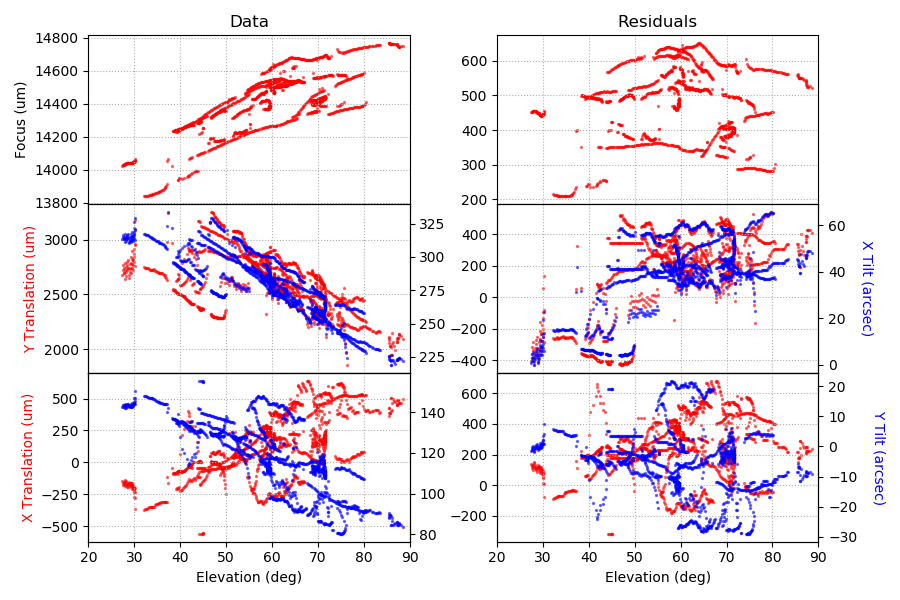

In [8]:
plot_m2(bino_table, model=bino_model)

F/9 data is taken more sporadically so there is a lot less of it. The trends are still clear and well-described by our current model modulo significant shifts in the zeropoints. 

<IPython.core.display.Javascript object>


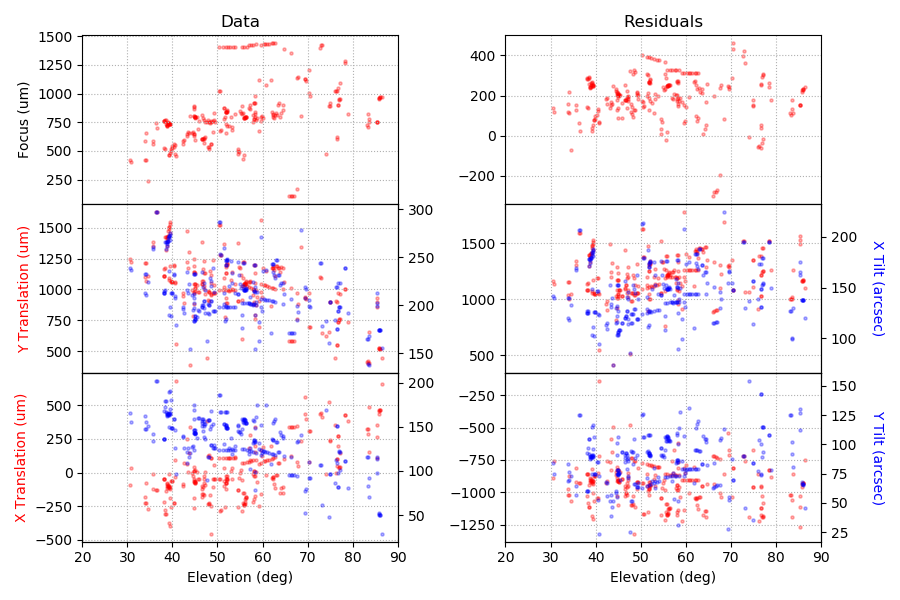

In [9]:
plot_m2(f9_table, model=f9_model, size=5, alpha=0.3)

In [11]:
bino_resid = {}
for k in M2_KEYS:
    bino_resid[k] = bino_table[k] - bino_model(k, bino_table['EL'], bino_table['OSSTEMP'])
f9_resid = {}
for k in M2_KEYS:
    f9_resid[k] = f9_table[k] - f9_model(k, f9_table['EL'], f9_table['OSSTEMP'])

Look at the median and RMS of the residuals to get the corrections we need to make to the zeropoints. Interesting that the tilt/pointing scatter for F/9 is almost double what it is for F/5...

In [12]:
for k, v in bino_resid.items():
    print(f"Median {k} = {np.median(v)} +/- {np.std(v)}")

Median TRANSX = 234.0942286994154 +/- 187.6580105511664
Median TILTY = -4.914114012303656 +/- 11.299941438390457
Median TRANSY = 230.65113106706758 +/- 248.69663598121596
Median TILTX = 40.55717320212406 +/- 15.491927908032338
Median TRANSZ = 495.82390385358485 +/- 104.8485821321308


In [13]:
for k, v in f9_resid.items():
    print(f"Median {k} = {np.median(v)} +/- {np.std(v)}")

Median TRANSX = -928.7612766156183 +/- 152.72576718536803
Median TILTY = 85.38256202627947 +/- 21.211732506427104
Median TRANSY = 1199.4478549946652 +/- 190.6215173377244
Median TILTX = 143.2394296707828 +/- 26.488105138024576
Median TRANSZ = 202.33748705277566 +/- 116.01985033235292


An interesting trend that i found is that the Y-axis (left/right) tilt residuals in the Binospec data show a clear trend with azimuth. This appears to imply that there is a systematic error in the mount's pointing model that is being compensated for with the M2 hexapod. 

<IPython.core.display.Javascript object>


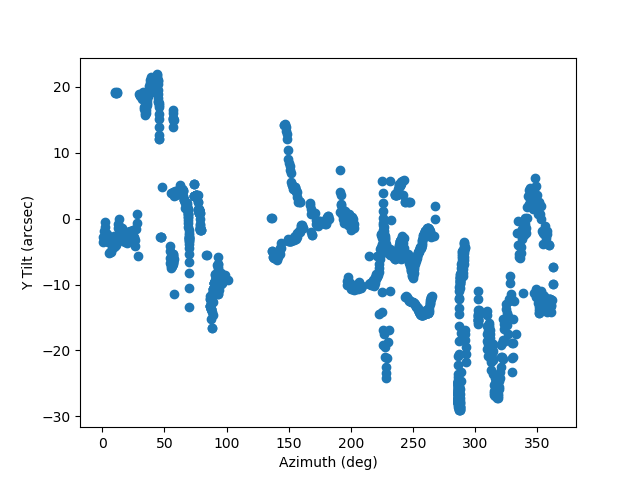

In [14]:
az = bino_table['AZ']
az[az < 0] += 360.
fig = plt.scatter(az, bino_resid['TILTY'])
fig.axes.set_xlabel("Azimuth (deg)")
fig.axes.set_ylabel("Y Tilt (arcsec)")
plt.show()

The trend is not clear in the F/9 data since there is significantly more scatter, but not ruled out, either.

<IPython.core.display.Javascript object>


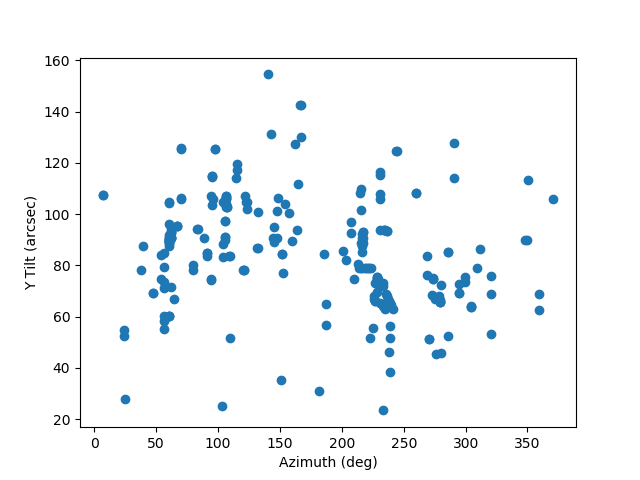

In [15]:
f9_az = f9_table['AZ']
f9_az[f9_az < 0] += 360.
fig = plt.scatter(f9_az, f9_resid['TILTY'])
fig.axes.set_xlabel("Azimuth (deg)")
fig.axes.set_ylabel("Y Tilt (arcsec)")
plt.show()